We want to create an initial set of template waveforms, one template being a three-component seismogram.

This is what we want to keep in mind to have for all three channels:
- Windows with both P- and S- pick
- Only one earthquake in the window
- Raw SNR > 2 for P-wave
- Raw SNR > 3 for S-wave
- Prioritize higher magnitudes first

To-do:
- For each earthquake, loop over all 3 channels and check P and S SNR in each
- If both SNRs are high enough for all 3 channels (6 checks), the event gets saved in a list

In [1]:
import obspy
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd
import time; import datetime
from obspy.core.utcdatetime import UTCDateTime
from obspy.clients.fdsn.client import Client
import pyasdf

In [2]:
def read_files(base_folder):
    ''' Reads in earthquake catalog files from CSS format into useful pandas dataframes
    
        Inputs:
        base_folder = string containing name of year and month of interest, e.g. '2019_01'
        
        Outputs dataframes:
        assoc
        arrivals
        origin
    '''
    
    
    base_dir = 'catalog_css/'+base_folder+'/'
    
    arr_files = glob.glob(base_dir + 'catalog_XO_*arrival')
    assoc_files = glob.glob(base_dir + 'catalog_XO_*assoc')
    origin_files = glob.glob(base_dir + 'catalog_XO_*origin')
    
    # Read data into pandas dataframe
    arrivals = pd.concat([pd.read_csv(f,header=None,delim_whitespace=True) for f in arr_files])
    assoc = pd.concat([pd.read_csv(f,header=None,delim_whitespace=True) for f in assoc_files])
    origin = pd.concat([pd.read_csv(f,header=None,delim_whitespace=True) for f in origin_files])

    # Rename some columns for clarity:
    assoc=assoc.rename(columns={0: "arrivalid", 1: "originid",2:"stationcode",3:"phase"})
    origin = origin.rename(columns={4:'originid',3:'epochtime',20:'magnitude'})
    arrivals=arrivals.rename(columns={2: "arrivalid", 6: "channel",0:"stationcode", 1:'epochtime',7:'phase'})
    
    return(assoc,arrivals,origin)

In [3]:
def calc_snr(stream,sampleind,phase):
    # Calculate SNR of arrival
    # INPUTS:
    # stream = obspy-formatted waveform object
    # sampleind = index in the stream's data of desired arrival for which to calculate SNR
    # phase = type of arrival as a string, either 'P' or 'S'
    #
    # OUTPUT:
    # snr = float object of calculated SNR for the input index
    
    if phase == 'P':
        window = [5,5] # in seconds
    if phase == 'S':
        window = [5,5]
    try:
        data = stream[0].data
        sr = int(stream[0].stats.sampling_rate)
        snr_num = max(abs(data[sampleind:(sampleind+(window[0]*sr))]))
        snr_denom = np.sqrt(np.mean((data[(sampleind-(window[1]*sr)):sampleind])**2))
        snr = snr_num/snr_denom
    except:
        snr = float('NaN')
    return(snr)

1551996729.29
2019-03-07 22:12:09.288390


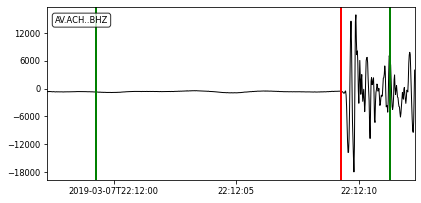

SNR = 25.4348632352


KeyboardInterrupt: Interrupted by user

In [7]:
# Load catalog info for one month
month = '2019_03'
(assoc,arrivals,origin) = read_files(month)

# Sort events by magnitude, descending
origin = origin.sort_values(by=['magnitude'],ascending=False)
origin_ids = origin['originid']

# Loop through events
for id in origin_ids:

    # Get arrivals associated with this earthquake
    subset = assoc.loc[assoc['originid']==id]
    arrival_subset = arrivals.iloc[subset['arrivalid']-1]
    arrival_subset.reset_index(drop=True,inplace=True)
    
    # Get station names
    stations = arrival_subset['stationcode']

    # Get list of stations that have both P and S pick
    repeats = []
    for station in stations:
        sub = arrival_subset.loc[(arrival_subset['stationcode']==station)]
        if len(np.unique(sub['phase']))>1:
            repeats.append(station)
   
    # Loop through P-wave picks
    repeat_subset = arrival_subset.loc[(arrival_subset['stationcode'].isin(repeats))]
    repeat_subset = repeat_subset.drop_duplicates(subset=['stationcode'])
    repeat_subset.reset_index(drop=True,inplace=True)

    for i in range(0,len(repeat_subset)):
        pick = repeat_subset.iloc[i]
        
        # Skip global array stations that have low sample rates and complicated location codes
        if len(pick['stationcode'])>3:
            continue
            
        # P arrival time:
        pick_epoch = pick['epochtime']
        print(pick_epoch)
        basetime = datetime.datetime.utcfromtimestamp(pick_epoch)
        print(basetime)
        
        # We want the streams for x minutes before and after the pick time:
        t1 = UTCDateTime(basetime)-datetime.timedelta(minutes = 2)
        t2 = UTCDateTime(basetime)+datetime.timedelta(minutes = 10)

        # Now we query the data from IRIS for each of the stations 20 min before and after the origin time, and add it to the master stream:
        client = Client("IRIS")

        # Download the streams INCLUDING the instrument response:
        channel_base = pick['channel'][0:2]
        # st = client.get_waveforms("XO,AK,AV",pick['stationcode'], "--",channel_base+'*', t1, t2,attach_response=True)
        st = client.get_waveforms("XO,AK,AV",pick['stationcode'], "--",channel_base+'Z', t1, t2,attach_response=True)  
    
        # Plot the raw waveform:
        %matplotlib inline
        fig = plt.figure()
        t11 = UTCDateTime(basetime)-datetime.timedelta(seconds = 12)
        t22 = UTCDateTime(basetime)+datetime.timedelta(seconds = 3)
        st.plot(fig = fig,starttime=t11,endtime=t22) 
        plt.axvline(x=UTCDateTime(basetime),linewidth=2, color='r')
        plt.axvline(x=UTCDateTime(basetime)-datetime.timedelta(seconds = 10),linewidth=2,color='g')
        plt.axvline(x=UTCDateTime(basetime)+datetime.timedelta(seconds = 2),linewidth=2,color='g')
        plt.show()
        # st.spectrogram(log=True, title=str(st[0].stats.starttime))
        
        # Calculate SNR of arrival
        sr = int(st[0].stats.sampling_rate)
        p_sampleind = ((2*60)*sr)-1 # index of sample that contains P pick
        snr = calc_snr(st,p_sampleind,'P')
        print('SNR = ' + str(snr))


        input("Press Enter to continue...")


Below:
Loops over earthquakes, then loops over stations with both a P and S pick for that earthquake, and checks for which ones have P and S picks with high SNR on all 3 channels of the stations

In [13]:
# Connect to asdf h5 file
ds = pyasdf.ASDFDataSet("test_file100.h5", compression="gzip-3")

# Loop over months:
months = ['2018_12']
master_success=0
for month in months:
    print(month)
    # Load catalog info for one month
    ml_path = 'catalog_css/'+month+'/XO_'+month+'.quakeml'
    (assoc,arrivals,origin) = read_files(month)

    # Sort events by magnitude, descending
    origin = origin.sort_values(by=['magnitude'],ascending=False)
    origin_ids = origin['originid']
    
    success=0
    ev_count = -1
    # Loop through events
    for id in origin_ids:
        # Get magnitude for this earthquake
        ev_count += 1
        mag = origin.iloc[ev_count]['magnitude']

        # Get arrivals associated with this earthquake
        subset = assoc.loc[assoc['originid']==id]
        arrival_subset = arrivals.iloc[subset['arrivalid']-1]
        arrival_subset.reset_index(drop=True,inplace=True)

        # Get station names
        stations = arrival_subset['stationcode']

        # Get list of stations that have both P and S pick
        repeats = []
        for station in stations:
            sub = arrival_subset.loc[(arrival_subset['stationcode']==station)]
            if len(np.unique(sub['phase']))>1:
                repeats.append(station)
        repeat_subset = arrival_subset.loc[(arrival_subset['stationcode'].isin(repeats))]
        repeat_subset = repeat_subset.drop_duplicates(subset=['stationcode'])
        repeat_subset.reset_index(drop=True,inplace=True)

        # Loop over stations
        for i in range(0,len(repeat_subset)):
            pick = repeat_subset.iloc[i]
            station = pick['stationcode']
            p_pick = arrival_subset.loc[(arrival_subset['stationcode']==station)&(arrival_subset['phase']=='P')]
            s_pick = arrival_subset.loc[(arrival_subset['stationcode']==station)&(arrival_subset['phase']=='S')]
            p_time = datetime.datetime.utcfromtimestamp(p_pick.iloc[0]['epochtime'])
            s_time = datetime.datetime.utcfromtimestamp(s_pick.iloc[0]['epochtime'])
            sptime = float(str((s_time-p_time).seconds)+'.'+str((s_time-p_time).microseconds)) # S - P time in seconds


            # We want the streams for 12 minutes before and 10 min after the P:
            t1 = UTCDateTime(p_time)-datetime.timedelta(minutes = 12)
            t2 = UTCDateTime(p_time)+datetime.timedelta(minutes = 10)
            channel_base = p_pick.iloc[0]['channel'][0:2]
            channels = [channel_base+'Z',channel_base+'E,'+channel_base+'1',channel_base+'N,'+channel_base+'2']


            # Loop over channels
            j = 0
            all_psnr = []
            all_ssnr = []
            while j < 3:

                # Now we query the data from IRIS for the time band defined above:
                client = Client("IRIS")

                # Only do OBS stations!!!
                try:
                    st = client.get_waveforms("XO",station, "--",channels[j], t1, t2,attach_response=True)
                except:
                    break


                # print(station)
                # print(channels[j])
                station_mda = client.get_stations(network="XO", station=station)
                elev = station_mda[0][0].elevation
                if elev > -10:
                    break

                # Get index of the P and S pick
                nsamples = len(st[0].data)
                sr = int(st[0].stats.sampling_rate)
                p_sampleind = ((12*60)*sr)-1 # index of sample that contains P pick
                # s_sampleind = nsamples - ((10*60)*sr) # index of sample that contains S pick
                s_sampleind = int(np.floor((((12*60)+sptime)*sr))-1)


                # Calculate SNR of P and S pick
                p_snr = calc_snr(st,p_sampleind,'P')
                if p_snr < 2 or np.isnan(p_snr):
                    break
                s_snr = calc_snr(st,s_sampleind,'S')
                if s_snr < 3 or np.isnan(s_snr):
                    break
                all_psnr.append(p_snr)
                all_ssnr.append(s_snr)
                j += 1

    #             %matplotlib inline
    #             fig = plt.figure()
    #             st.plot(fig = fig,starttime=t1,endtime=t2) 
    #             plt.axvline(x=(p_time),linewidth=2, color='r')
    #             plt.axvline(x=UTCDateTime(s_time),linewidth=2, color='g')
    #             plt.title('Magnitude = '+str(mag)+', depth = '+str(elev))
    #             plt.show()
    #             fig = plt.figure()
    #             st.plot(fig = fig,starttime=UTCDateTime(p_time)-datetime.timedelta(seconds = 12),endtime=UTCDateTime(s_time)+datetime.timedelta(seconds = 12)) 
    #             plt.axvline(x=(p_time),linewidth=2, color='r')
    #             plt.axvline(x=UTCDateTime(s_time),linewidth=2, color='g')
    #             plt.show()


                # If all 3 channels are good to go, save it!
                if j==3:
                    success += 1
                    st = client.get_waveforms("XO",station, "--",channels[0]+','+channels[1]+','+channels[2], t1, t2,attach_response=True)
                    ds.add_waveforms(st,tag='raw_recording_'+str(id))
                    ds.add_stationxml(station_mda)
                    parameters = {"p_time":p_pick.iloc[0]['epochtime'],"s_time":s_pick.iloc[0]['epochtime'],"magnitude":mag,"station_elev":elev,
                                 "p_snr_z":all_psnr[0],"s_snr_z":all_ssnr[0],"p_snr_e":all_psnr[1],
                                 "s_snr_e":all_ssnr[1],"p_snr_n":all_psnr[2],"s_snr_n":all_ssnr[2],
                                 "event_id":id}
                    ds.add_auxiliary_data(data=np.random.random(1),data_type='Metadata',path='XO_'+station+'_'+str(id),parameters=parameters)
                    print(success)
                    # input("Press Enter to continue...")

            if success==15:
                break
        if success==15:
            master_success=master_success + success
            print('Finished a month!')
            break

        


2018_12
1
2
3
4
5
6
7
8
9


<ipython-input-3-37589f3f170c>:19: RuntimeWarning: invalid value encountered in sqrt
  snr_denom = np.sqrt(np.mean((data[(sampleind-(window[1]*sr)):sampleind])**2))
<ipython-input-3-37589f3f170c>:19: RuntimeWarning: invalid value encountered in sqrt
  snr_denom = np.sqrt(np.mean((data[(sampleind-(window[1]*sr)):sampleind])**2))


10
11
12
13
14
15
Finished a month!


In [14]:
ds = pyasdf.ASDFDataSet('test_file100.h5')

count = 0
for station in ds.waveforms:
    tags=station.get_waveform_tags()
    count = count + len(tags)


print(count)
ds.waveforms.list()

105


['XO.LA23',
 'XO.LA29',
 'XO.LA33',
 'XO.LA34',
 'XO.LA39',
 'XO.LD36',
 'XO.LD40',
 'XO.LD41',
 'XO.LD44',
 'XO.LD45',
 'XO.LT01',
 'XO.LT05',
 'XO.LT07',
 'XO.LT10',
 'XO.LT17',
 'XO.LT20',
 'XO.WD48',
 'XO.WD49',
 'XO.WD50',
 'XO.WD51',
 'XO.WD52',
 'XO.WD54',
 'XO.WD55',
 'XO.WD57',
 'XO.WD58',
 'XO.WD59',
 'XO.WD61',
 'XO.WD62',
 'XO.WD64',
 'XO.WD65',
 'XO.WD66',
 'XO.WD67',
 'XO.WD68',
 'XO.WD69',
 'XO.WD70',
 'XO.WS71',
 'XO.WS72']

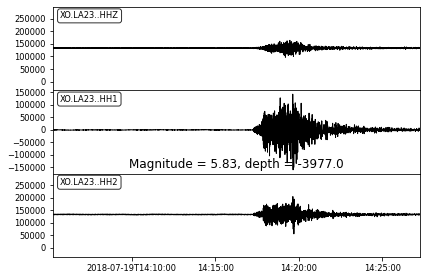

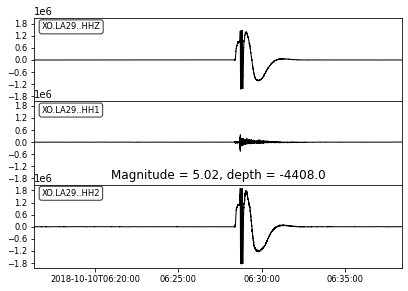

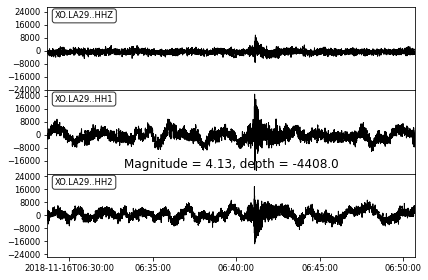

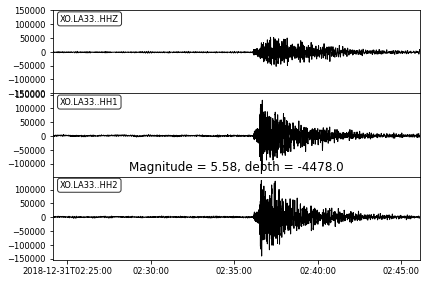

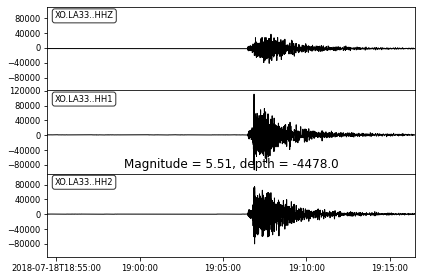

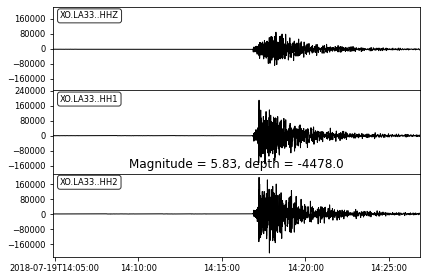

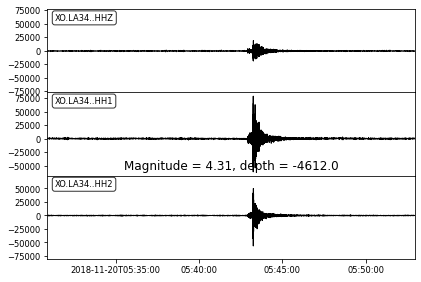

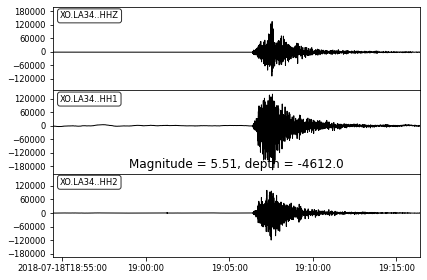

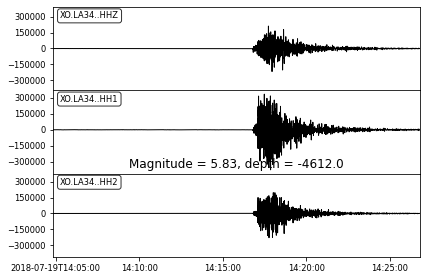

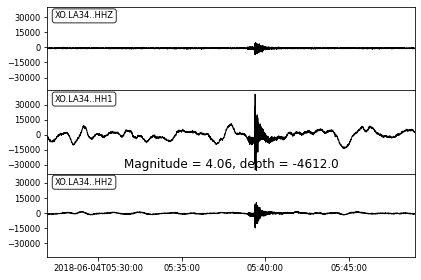

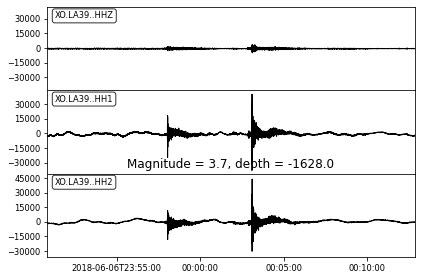

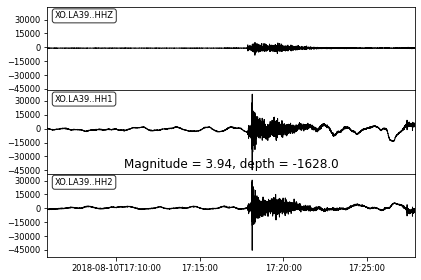

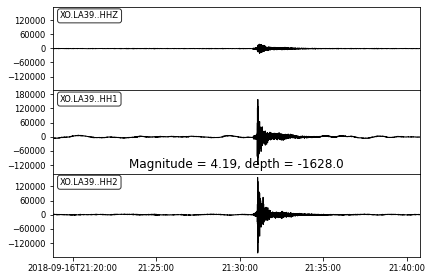

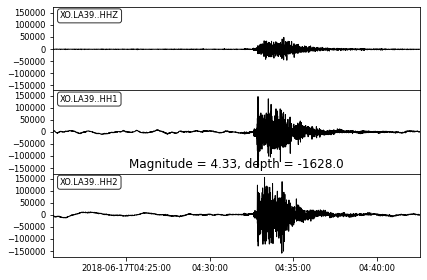

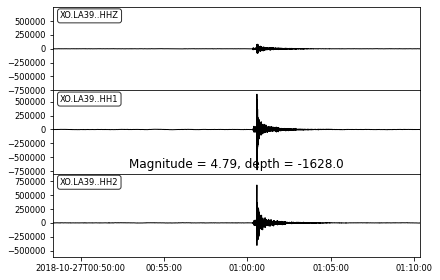

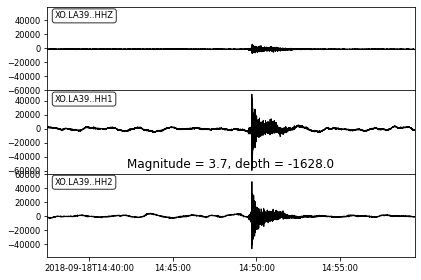

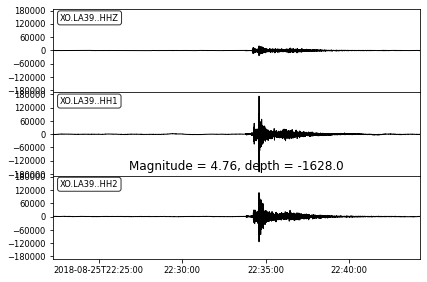

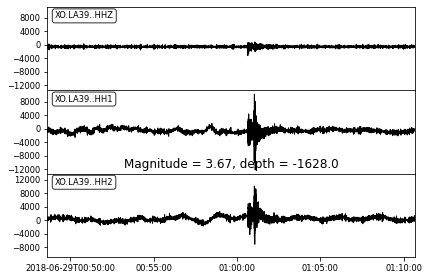

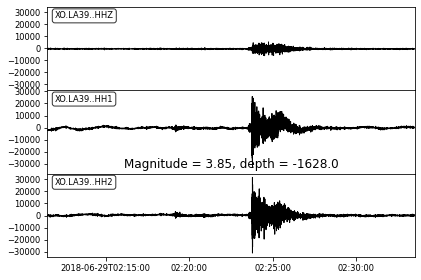

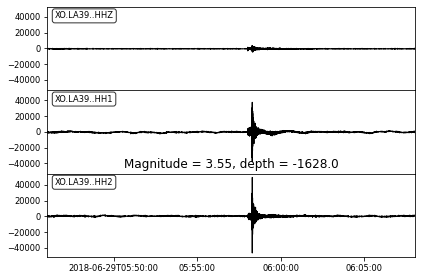

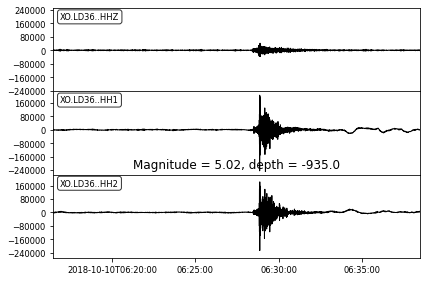

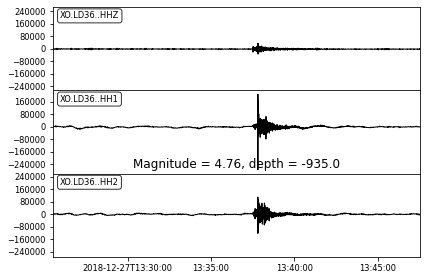

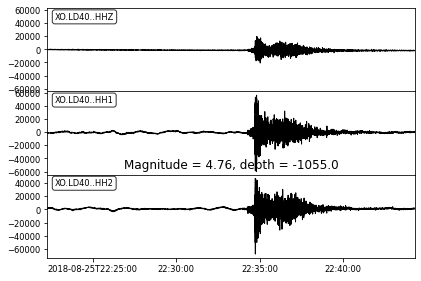

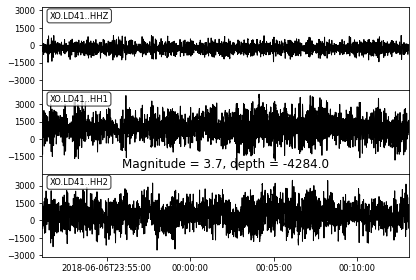

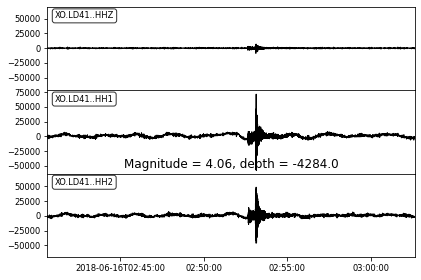

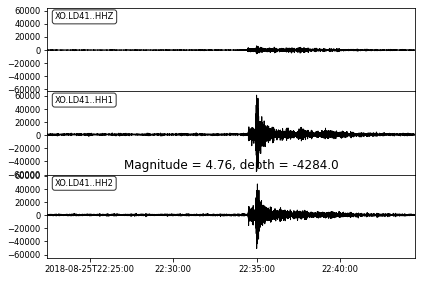

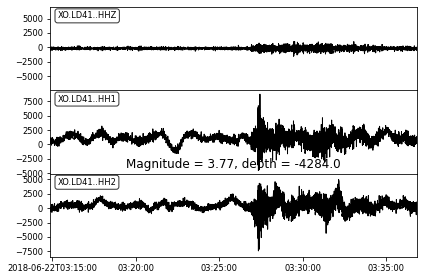

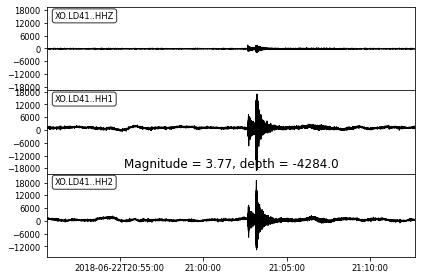

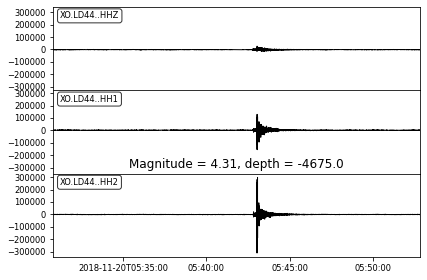

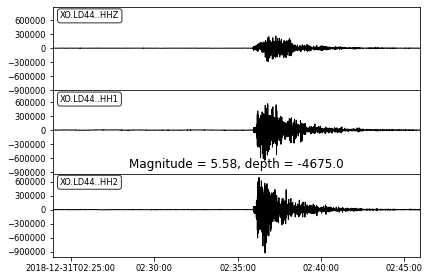

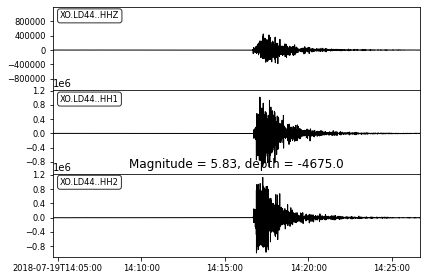

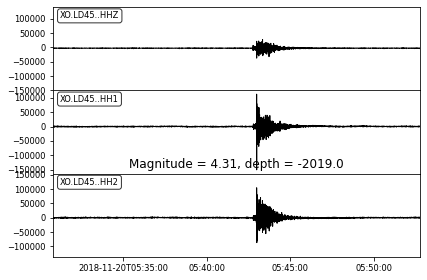

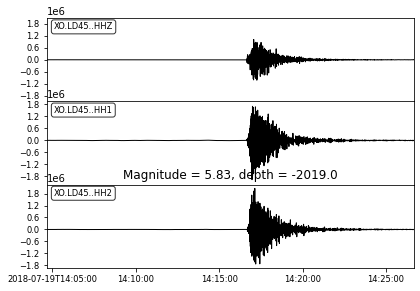

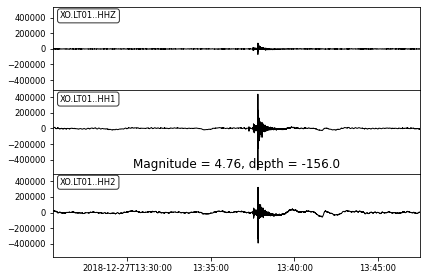

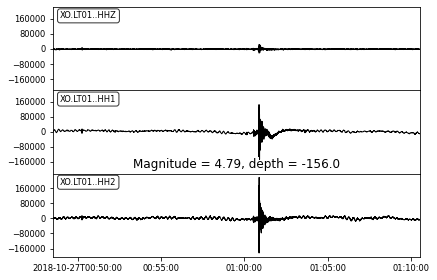

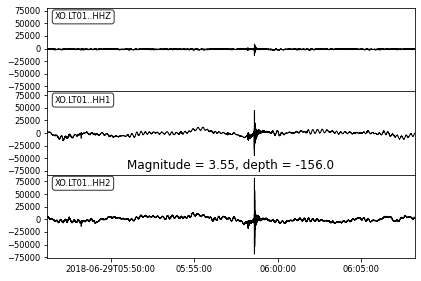

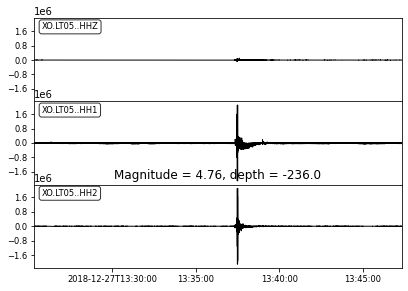

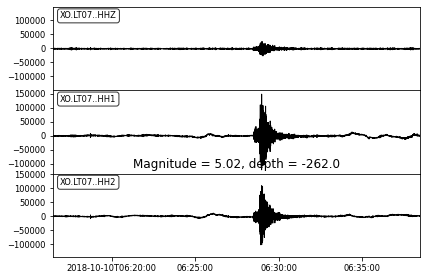

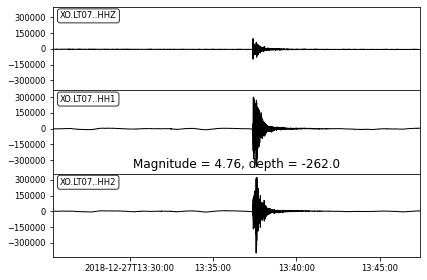

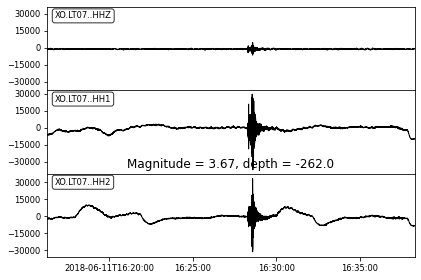

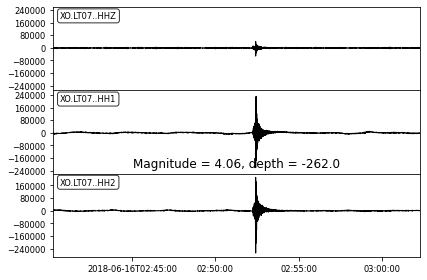

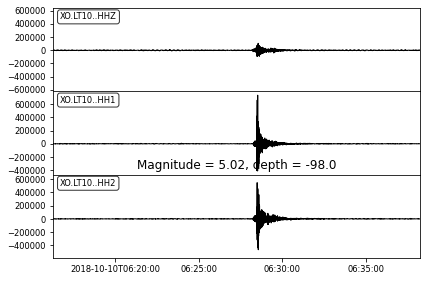

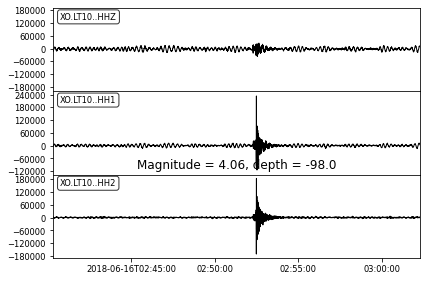

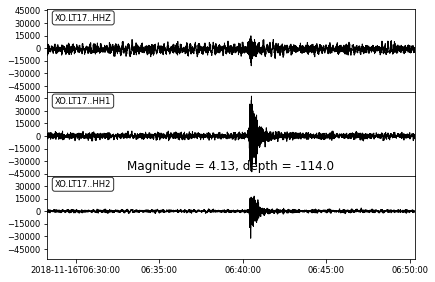

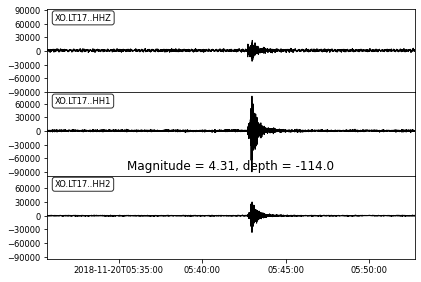

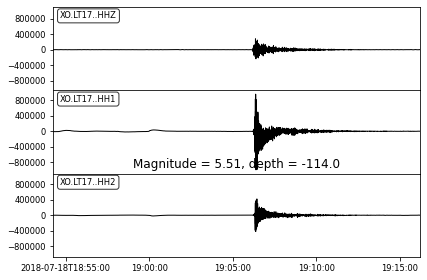

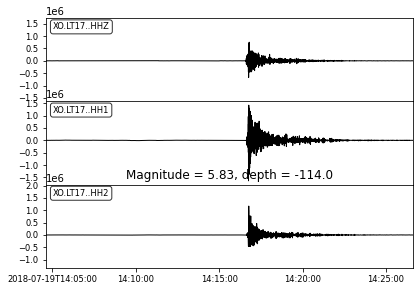

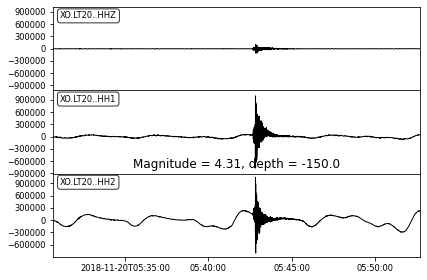

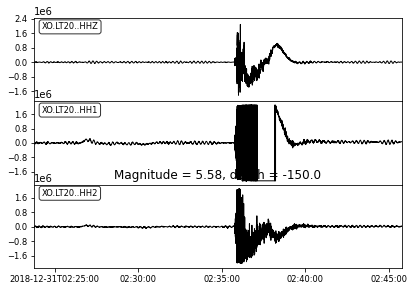

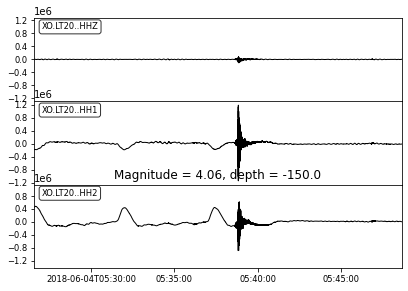

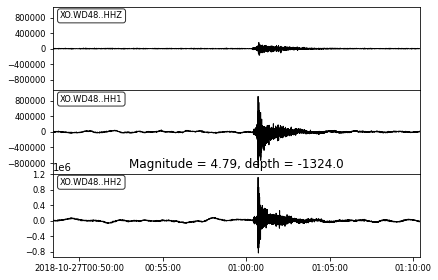

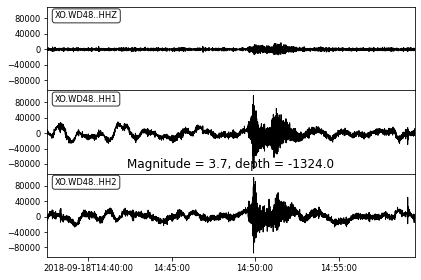

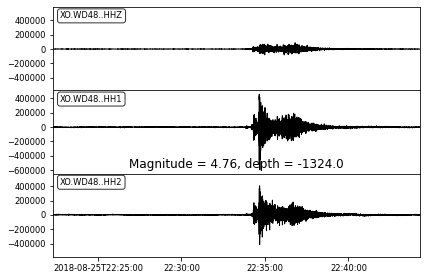

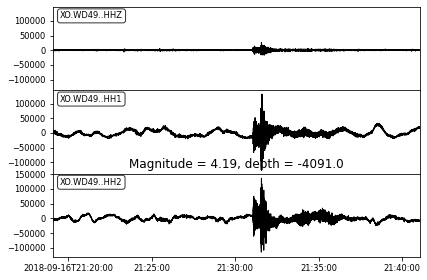

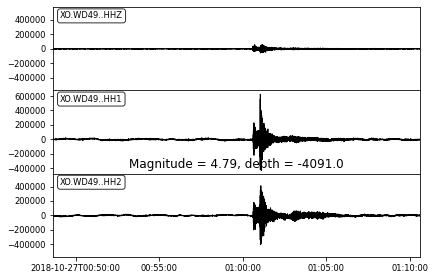

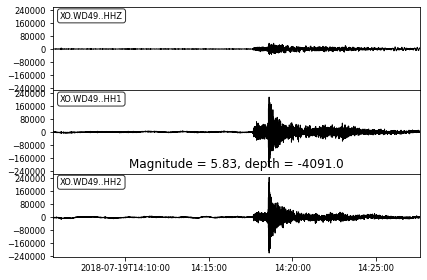

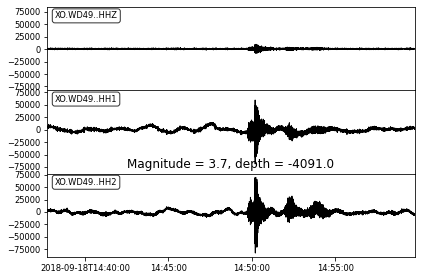

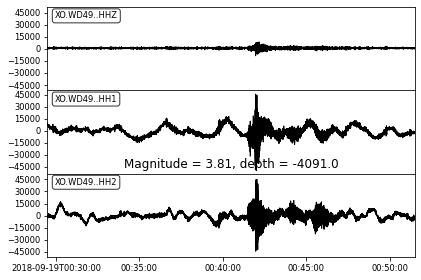

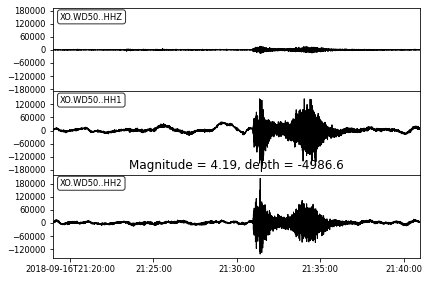

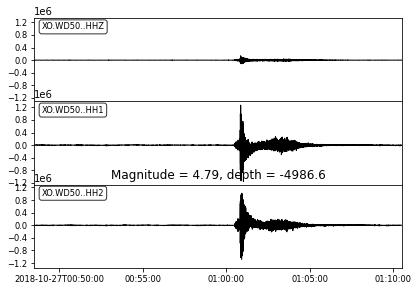

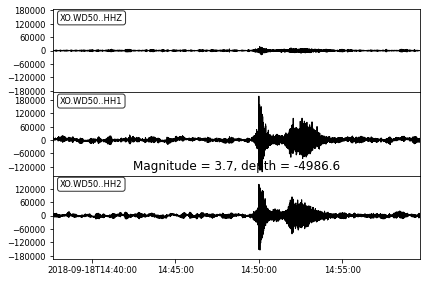

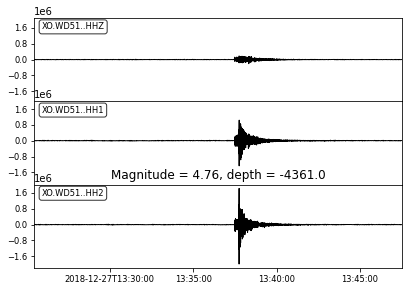

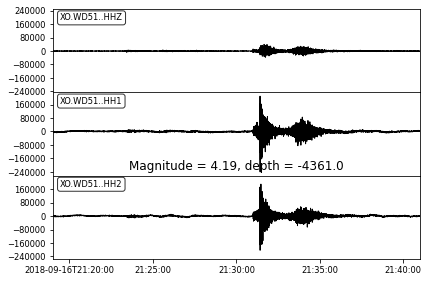

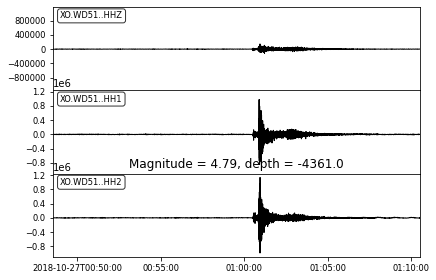

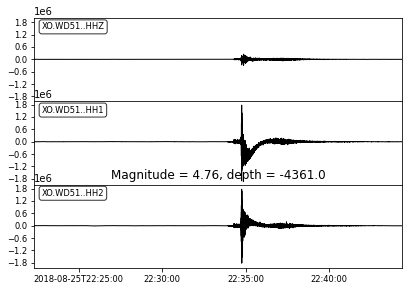

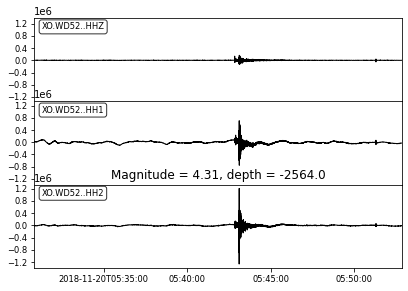

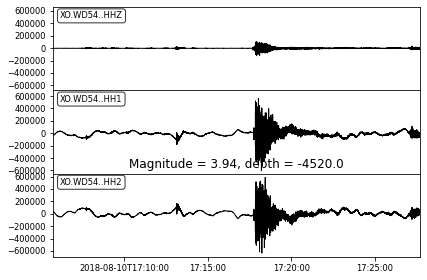

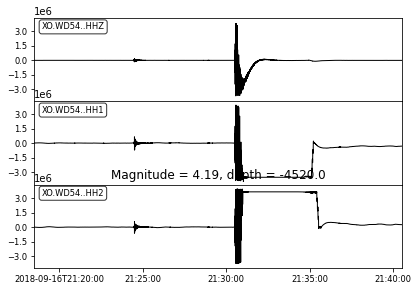

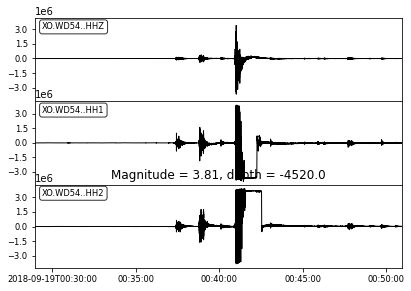

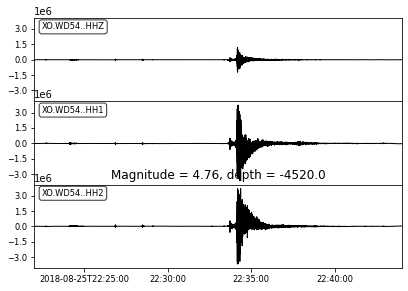

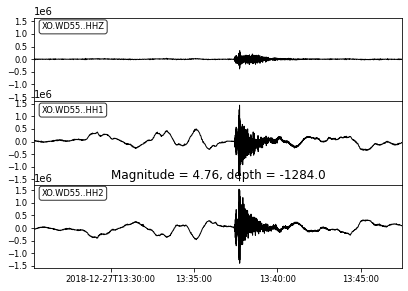

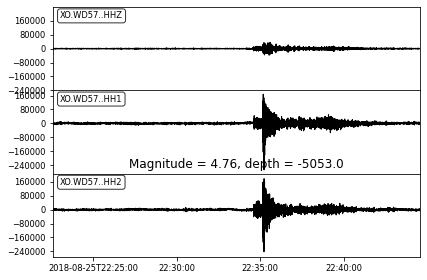

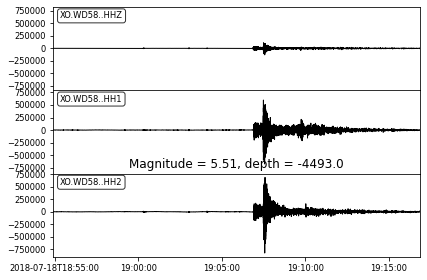

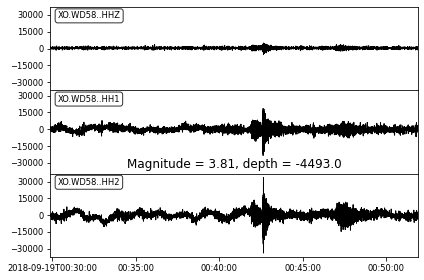

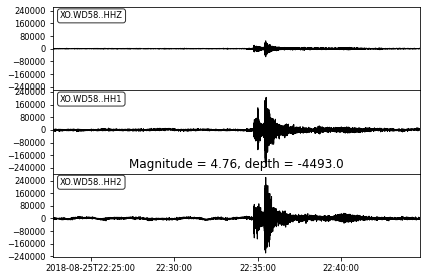

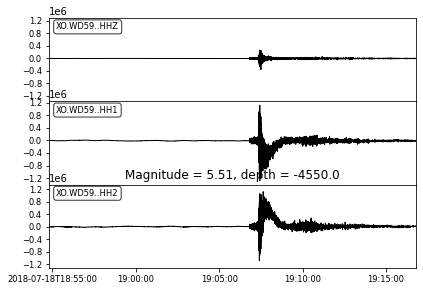

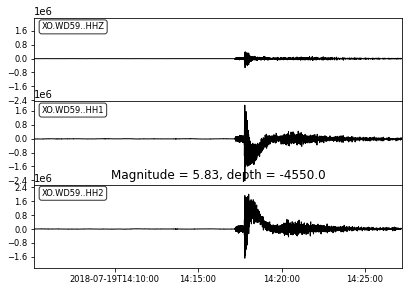

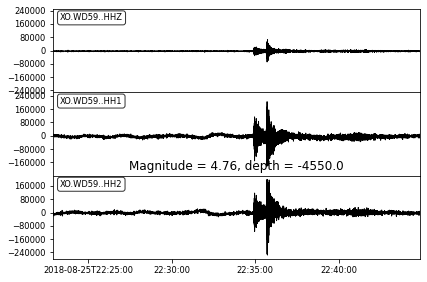

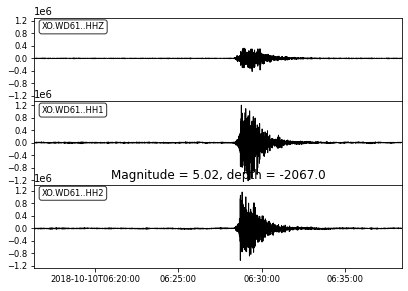

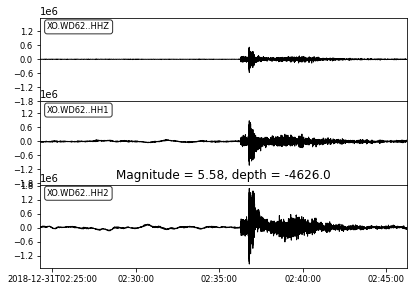

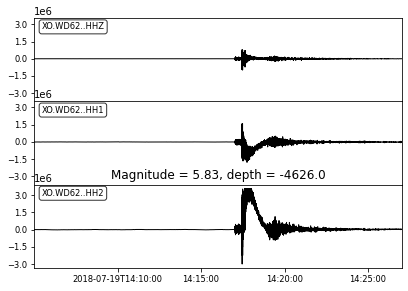

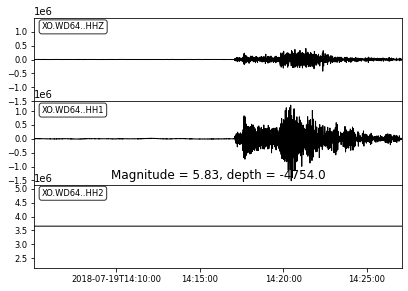

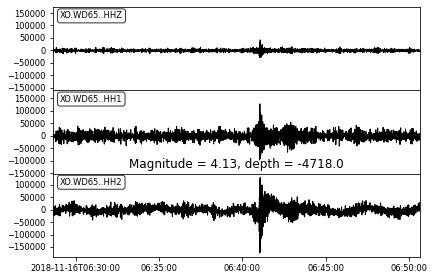

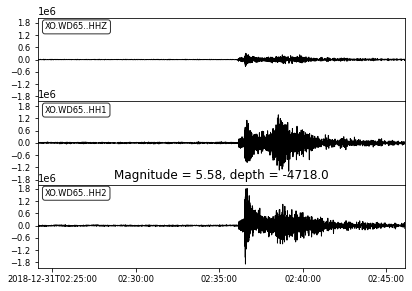

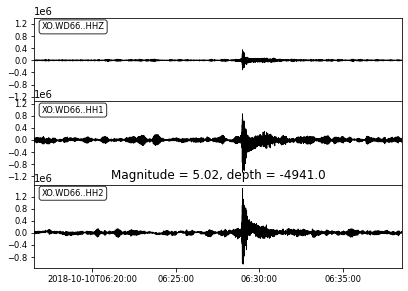

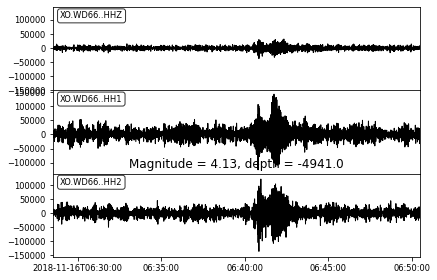

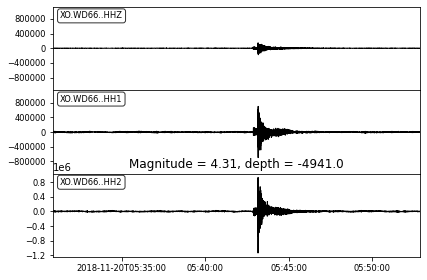

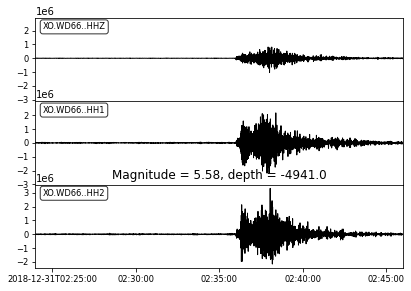

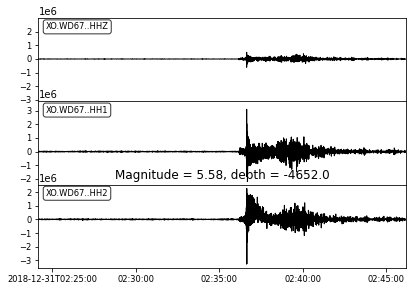

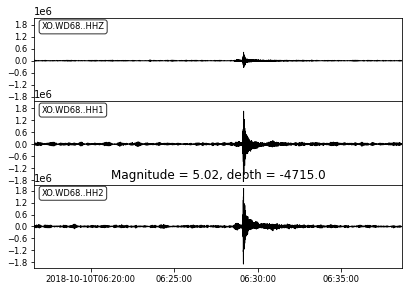

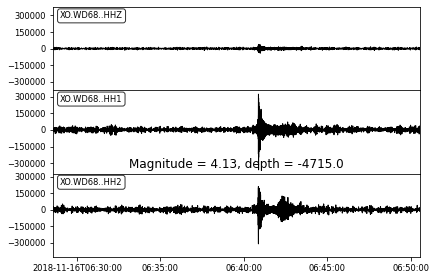

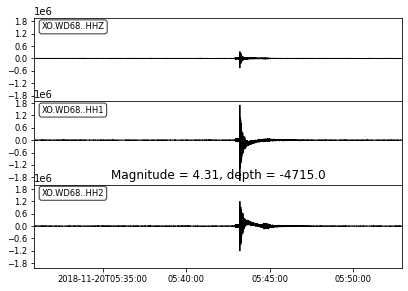

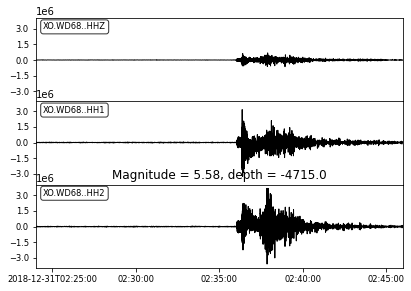

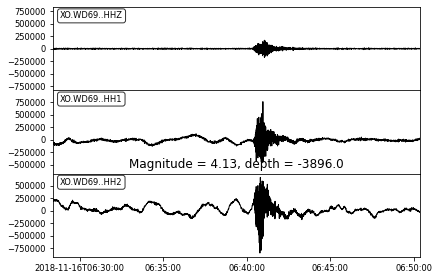

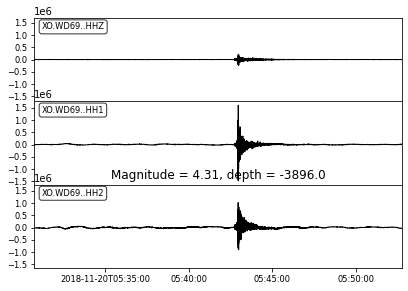

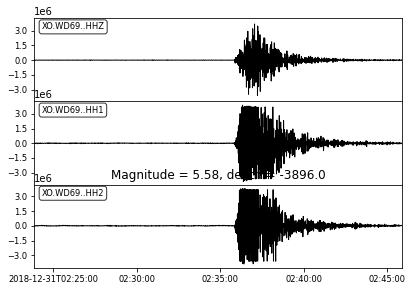

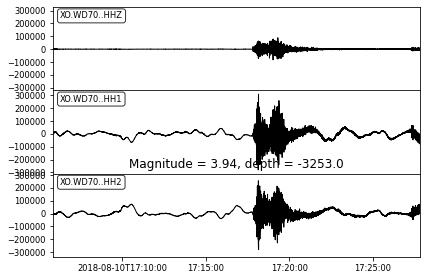

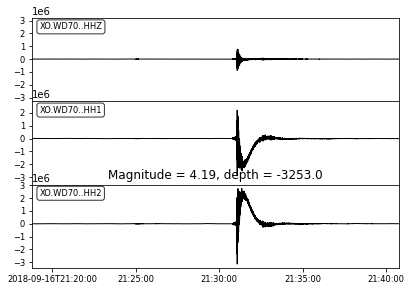

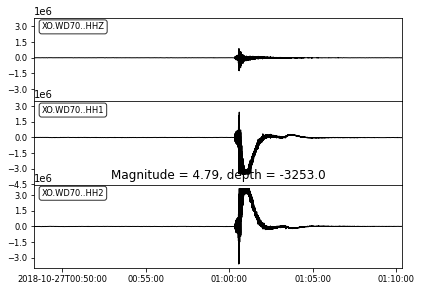

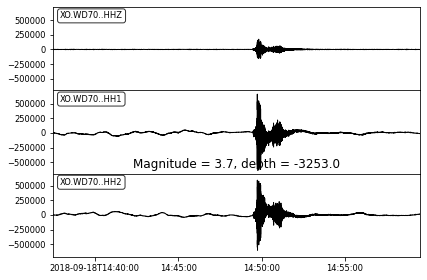

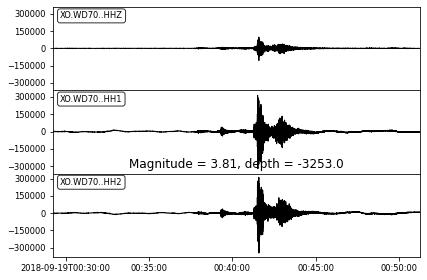

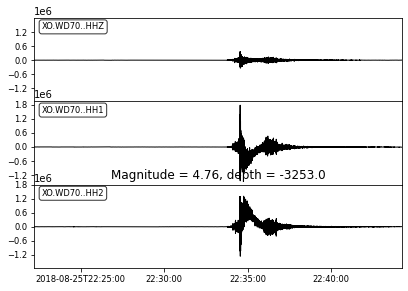

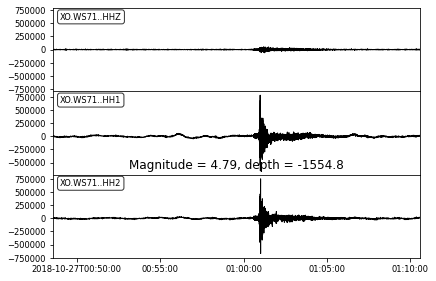

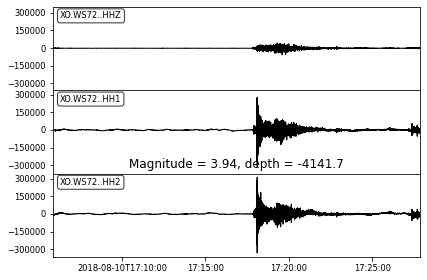

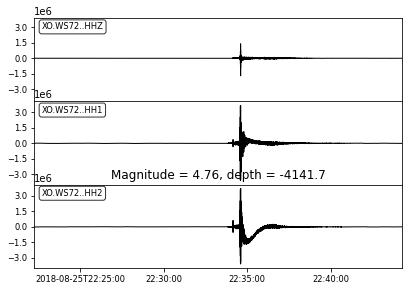

In [15]:
ds2 = pyasdf.ASDFDataSet("test_file100.h5")
ds2.waveforms.list()

# print(ds2.waveforms['XO.LA39'])


for station in ds2.waveforms:
    tags=station.get_waveform_tags()
    for tag in tags:
        st=eval('station.'+tag)
        ev_id=tag[14:]
        stacode=st[0].stats.station
        for meta in ds2.auxiliary_data['Metadata']:
            if (meta.path=='XO_'+stacode+'_'+str(ev_id)):
                mag = meta.parameters['magnitude']
                elev = meta.parameters['station_elev']
                break
        %matplotlib inline
        fig = plt.figure()
        st.plot(fig = fig) 
        plt.title('Magnitude = '+str(mag)+', depth = '+str(elev))
        plt.show()
         